# Introduction to Optimal Transport with Python

#### *Rémi Flamary, Nicolas Courty*

## POT installation

+ Install with pip:
```bash
pip install pot
```
+ Install with conda
```bash
conda install -c conda-forge pot
```

## POT Python Optimal Transport Toolbox

#### Import the toolbox

In [1]:
import numpy as np # always need it
import scipy as sp # often use it
import pylab as pl # do the plots

import ot # ot 

import time

#### Getting help

Online  documentation : [http://pot.readthedocs.io](http://pot.readthedocs.io) 

Or inline help:


In [2]:
help(ot.dist)

Help on function dist in module ot.utils:

dist(x1, x2=None, metric='sqeuclidean', p=2, w=None)
    Compute distance between samples in :math:`\mathbf{x_1}` and :math:`\mathbf{x_2}`
    
    .. note:: This function is backend-compatible and will work on arrays
        from all compatible backends.
    
    Parameters
    ----------
    
    x1 : array-like, shape (n1,d)
        matrix with `n1` samples of size `d`
    x2 : array-like, shape (n2,d), optional
        matrix with `n2` samples of size `d` (if None then :math:`\mathbf{x_2} = \mathbf{x_1}`)
    metric : str | callable, optional
        'sqeuclidean' or 'euclidean' on all backends. On numpy the function also
        accepts  from the scipy.spatial.distance.cdist function : 'braycurtis',
        'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice',
        'euclidean', 'hamming', 'jaccard', 'kulczynski1', 'mahalanobis',
        'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean',
        'sok

## First OT Problem

We will solve the Bakery/Cafés problem of transporting croissants from a number of Bakeries to Cafés in a City (In this case Manhattan). We did a quick google map search in Manhattan for bakeries and Cafés:

![bak.png](https://remi.flamary.com/cours/otml/bak.png)

We extracted from this search their positions and generated fictional production and sale number (that both sum to the same value).

We have acess to the position of Bakeries ```bakery_pos``` and their respective production ```bakery_prod``` which describe the source distribution. The Cafés where the croissants are sold are defiend also by their position ```cafe_pos``` and ```cafe_prod```. For fun we also provide a map ```Imap``` that will illustrate the position of these shops in the city.


Now we load the data



In [3]:
data=np.load('data/manhattan.npz')

bakery_pos=data['bakery_pos']
bakery_prod=data['bakery_prod']
cafe_pos=data['cafe_pos']
cafe_prod=data['cafe_prod']
Imap=data['Imap']

print('Bakery production: {}'.format(bakery_prod))
print('Cafe sale: {}'.format(cafe_prod))
print('Total croissants : {}'.format(cafe_prod.sum()))

Bakery production: [31. 48. 82. 30. 40. 48. 89. 73.]
Cafe sale: [82. 88. 92. 88. 91.]
Total croissants : 441.0


#### Plotting bakeries in the city

Next we plot the position of the bakeries and cafés on the map. The size of the circle is proportional to their production.


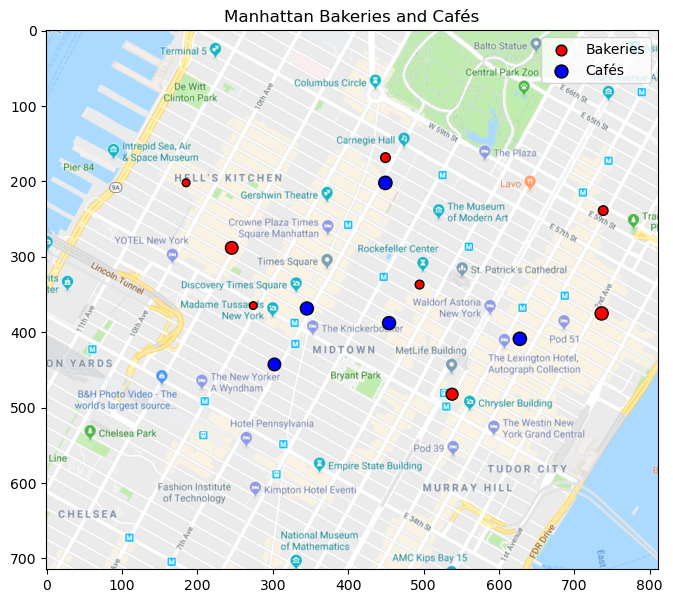

In [4]:

pl.figure(1,(8,7))
pl.clf()
pl.imshow(Imap,interpolation='bilinear') # plot the map
pl.scatter(bakery_pos[:,0],bakery_pos[:,1],s=bakery_prod,c='r', edgecolors='k',label='Bakeries')
pl.scatter(cafe_pos[:,0],cafe_pos[:,1],s=cafe_prod,c='b', edgecolors='k',label='Cafés')
pl.legend()
pl.title('Manhattan Bakeries and Cafés');


#### Cost matrix


We compute the cost matrix between the bakeries and the cafés, this will be the transport cost matrix. This can be done using the [ot.dist](http://pot.readthedocs.io/en/stable/all.html#ot.dist) that defaults to squared euclidean distance but can return other things such as cityblock (or manhattan distance). 



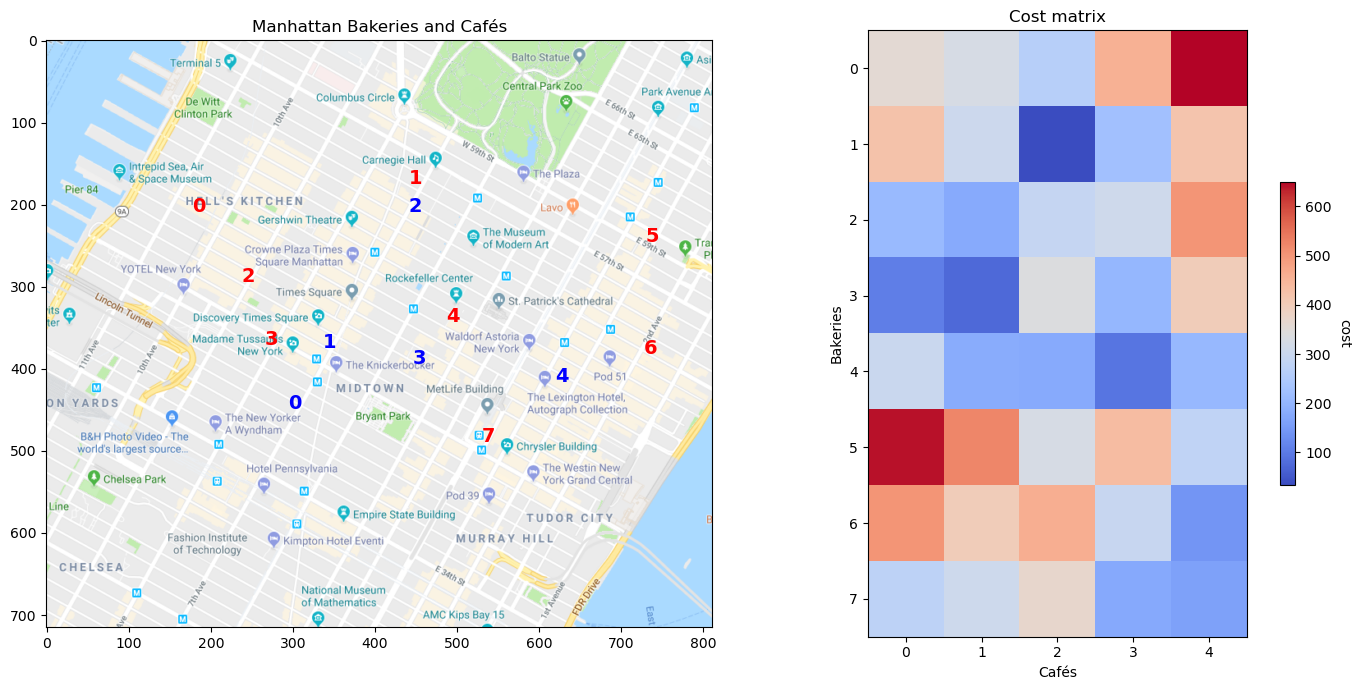

In [5]:
C = ot.dist(bakery_pos, cafe_pos, metric='cityblock')

labels = [str(i) for i in range(len(bakery_prod))]
f = pl.figure(2, (14, 7))
pl.clf()
pl.subplot(121)
pl.imshow(Imap, interpolation='bilinear')  # plot the map
for i in range(len(cafe_pos)):
    pl.text(cafe_pos[i, 0], cafe_pos[i, 1], labels[i], color='b',
            fontsize=14, fontweight='bold', ha='center', va='center')
for i in range(len(bakery_pos)):
    pl.text(bakery_pos[i, 0], bakery_pos[i, 1], labels[i], color='r',
            fontsize=14, fontweight='bold', ha='center', va='center')
pl.title('Manhattan Bakeries and Cafés')

ax = pl.subplot(122)
im = pl.imshow(C, cmap="coolwarm")
pl.title('Cost matrix')
cbar = pl.colorbar(im, ax=ax, shrink=0.5, use_gridspec=True)
cbar.ax.set_ylabel("cost", rotation=-90, va="bottom")

pl.xlabel('Cafés')
pl.ylabel('Bakeries')
pl.tight_layout()

#### Solving the OT problem with [ot.emd](http://pot.readthedocs.io/en/stable/all.html#ot.emd)

In [6]:
start = time.time()
ot_emd = ot.emd(bakery_prod, cafe_prod, C)
time_emd = time.time() - start

#### Transportation plan vizualization

A good vizualization of the OT matrix in the 2D plane is to denote the transportation of mass between a Bakery and a Café by a line. This can easily be done with a double ```for``` loop.

In order to make it more interpretable one can also use the ```alpha``` parameter of plot and set it to ```alpha=G[i,j]/G[i,j].max()```. 

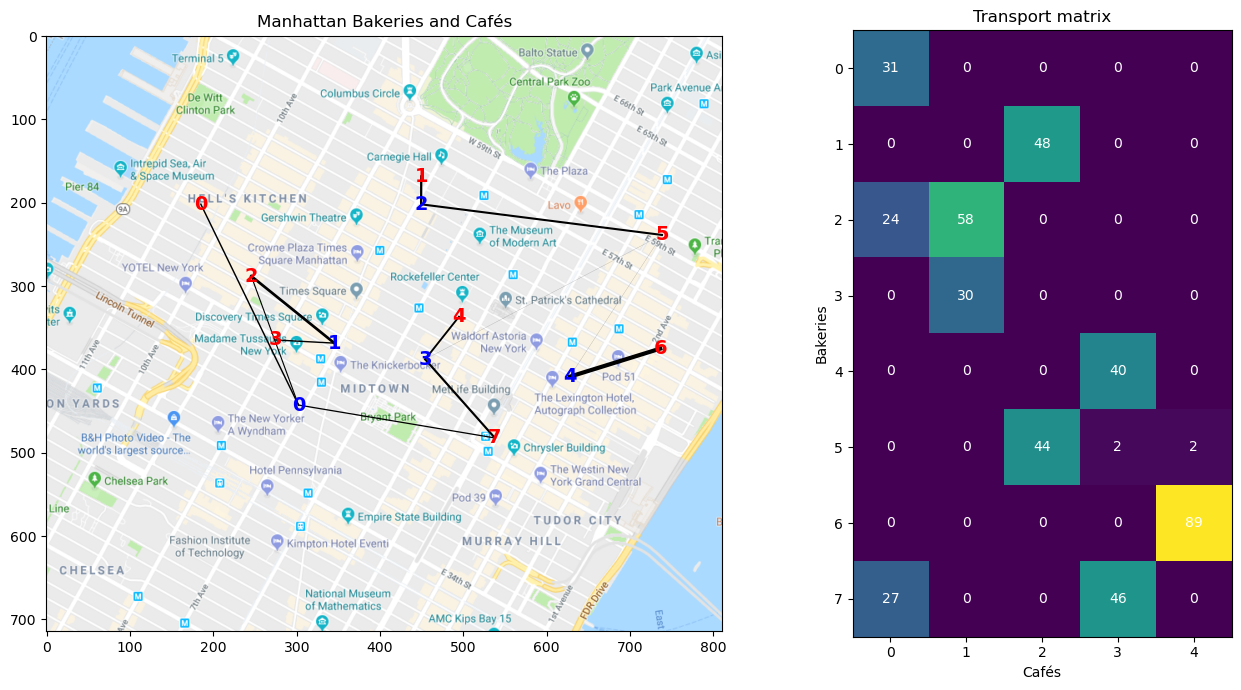

In [7]:
# Plot the matrix and the map
f = pl.figure(3, (14, 7))
pl.clf()
pl.subplot(121)
pl.imshow(Imap, interpolation='bilinear')  # plot the map
for i in range(len(bakery_pos)):
    for j in range(len(cafe_pos)):
        pl.plot([bakery_pos[i, 0], cafe_pos[j, 0]], [bakery_pos[i, 1], cafe_pos[j, 1]],
                '-k', lw=3. * ot_emd[i, j] / ot_emd.max())
for i in range(len(cafe_pos)):
    pl.text(cafe_pos[i, 0], cafe_pos[i, 1], labels[i], color='b', fontsize=14,
            fontweight='bold', ha='center', va='center')
for i in range(len(bakery_pos)):
    pl.text(bakery_pos[i, 0], bakery_pos[i, 1], labels[i], color='r', fontsize=14,
            fontweight='bold', ha='center', va='center')
pl.title('Manhattan Bakeries and Cafés')

ax = pl.subplot(122)
im = pl.imshow(ot_emd)
for i in range(len(bakery_prod)):
    for j in range(len(cafe_prod)):
        text = ax.text(j, i, '{0:g}'.format(ot_emd[i, j]),
                       ha="center", va="center", color="w")
pl.title('Transport matrix')

pl.xlabel('Cafés')
pl.ylabel('Bakeries')
pl.tight_layout()

#### OT loss and dual variables

The resulting wasserstein loss loss is of the form:

$W=\sum_{i,j}\gamma_{i,j}C_{i,j}$

where $\gamma$ is the optimal transport matrix.


In [8]:
W = np.sum(ot_emd * C)
print('Wasserstein loss (EMD) = {0:.2f}'.format(W))

Wasserstein loss (EMD) = 78182.34


#### Regularized OT with SInkhorn

The Sinkhorn algorithm is very simple to code. You can implement it directly using the following pseudo-code:

![sinkhorn.png](http://remi.flamary.com/cours/otml/sink.png)

An alternative is to use the POT toolbox with [ot.sinkhorn](http://pot.readthedocs.io/en/stable/all.html#ot.sinkhorn)

Be carefull to numerical problems. A good pre-provcessing for Sinkhorn is to divide the cost matrix ```C```
 by its maximum value.

In [9]:
# Compute Sinkhorn transport matrix from algorithm
reg = 0.1
K = np.exp(-C / C.max() / reg)
nit = 100
u = np.ones((len(bakery_prod), ))
for i in range(1, nit):
    v = cafe_prod / np.dot(K.T, u)
    u = bakery_prod / (np.dot(K, v))
ot_sink_algo = np.atleast_2d(u).T * (K * v.T)  # Equivalent to np.dot(np.diag(u), np.dot(K, np.diag(v)))

# Compute Sinkhorn transport matrix with POT
ot_sinkhorn = ot.sinkhorn(bakery_prod, cafe_prod, reg=reg, M=C / C.max())

# Difference between the 2
print('Difference between algo and ot.sinkhorn = {0:.2g}'.format(np.sum(np.power(ot_sink_algo - ot_sinkhorn, 2))))

Difference between algo and ot.sinkhorn = 3e-24


Min. of Sinkhorn's transport matrix = 0.012


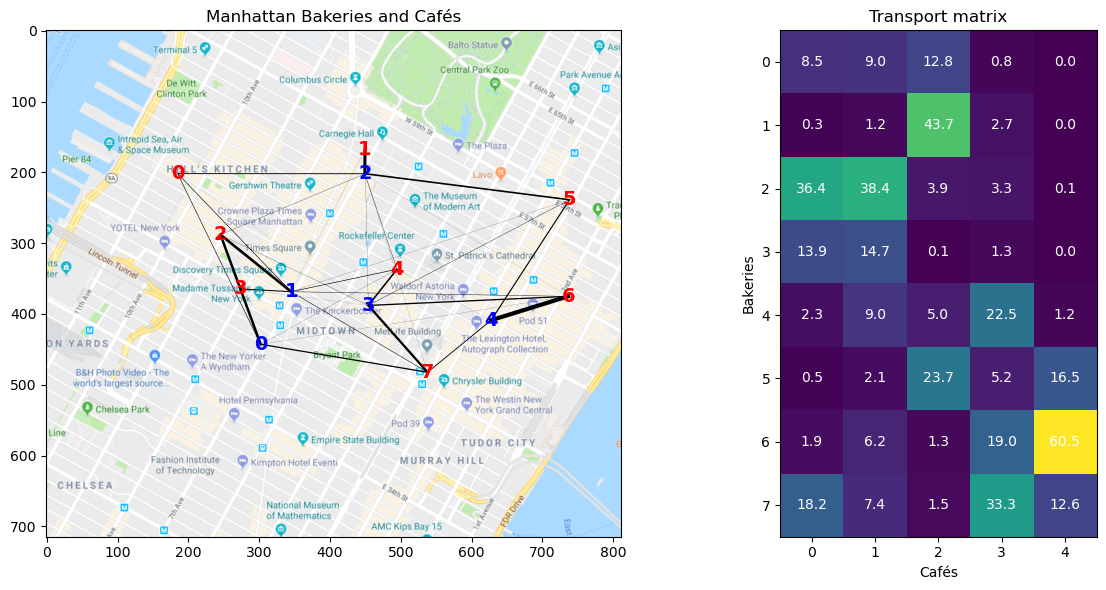

In [10]:
print('Min. of Sinkhorn\'s transport matrix = {0:.2g}'.format(np.min(ot_sinkhorn)))

f = pl.figure(4, (13, 6))
pl.clf()
pl.subplot(121)
pl.imshow(Imap, interpolation='bilinear')  # plot the map
for i in range(len(bakery_pos)):
    for j in range(len(cafe_pos)):
        pl.plot([bakery_pos[i, 0], cafe_pos[j, 0]],
                [bakery_pos[i, 1], cafe_pos[j, 1]],
                '-k', lw=3. * ot_sinkhorn[i, j] / ot_sinkhorn.max())
for i in range(len(cafe_pos)):
    pl.text(cafe_pos[i, 0], cafe_pos[i, 1], labels[i], color='b',
            fontsize=14, fontweight='bold', ha='center', va='center')
for i in range(len(bakery_pos)):
    pl.text(bakery_pos[i, 0], bakery_pos[i, 1], labels[i], color='r',
            fontsize=14, fontweight='bold', ha='center', va='center')
pl.title('Manhattan Bakeries and Cafés')

ax = pl.subplot(122)
im = pl.imshow(ot_sinkhorn)
for i in range(len(bakery_prod)):
    for j in range(len(cafe_prod)):
        text = ax.text(j, i, np.round(ot_sinkhorn[i, j], 1),
                       ha="center", va="center", color="w")
pl.title('Transport matrix')

pl.xlabel('Cafés')
pl.ylabel('Bakeries')
pl.tight_layout()

We notice right away that the matrix is not sparse at all with Sinkhorn, each bakery delivering croissants to all 5 cafés with that solution. Also, this solution gives a transport with fractions, which does not make sense in the case of croissants. This was not the case with EMD.

### Varying the regularization parameter in Sinkhorn

/Users/ben/miniconda3/lib/python3.10/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


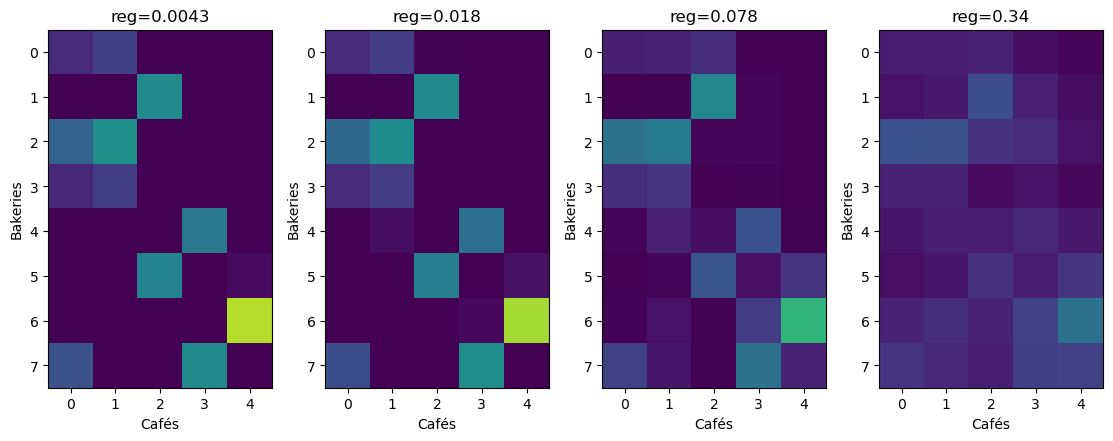

In [11]:
reg_parameter = np.logspace(-3, 0, 20)
W_sinkhorn_reg = np.zeros((len(reg_parameter), ))
time_sinkhorn_reg = np.zeros((len(reg_parameter), ))

f = pl.figure(5, (14, 5))
pl.clf()
max_ot = 100  # plot matrices with the same colorbar
for k in range(len(reg_parameter)):
    start = time.time()
    ot_sinkhorn = ot.sinkhorn(bakery_prod, cafe_prod, reg=reg_parameter[k], M=C / C.max())
    time_sinkhorn_reg[k] = time.time() - start

    if k % 4 == 0 and k > 0:  # we only plot a few
        ax = pl.subplot(1, 5, k // 4)
        im = pl.imshow(ot_sinkhorn, vmin=0, vmax=max_ot)
        pl.title('reg={0:.2g}'.format(reg_parameter[k]))
        pl.xlabel('Cafés')
        pl.ylabel('Bakeries')

    # Compute the Wasserstein loss for Sinkhorn, and compare with EMD
    W_sinkhorn_reg[k] = np.sum(ot_sinkhorn * C)
pl.tight_layout()

This series of graph shows that the solution of Sinkhorn starts with something very similar to EMD (although not sparse) for very small values of the regularization parameter, and tends to a more uniform solution as the regularization parameter increases.

### Wasserstein loss and computational time

Text(0, 0.5, 'Wasserstein loss')

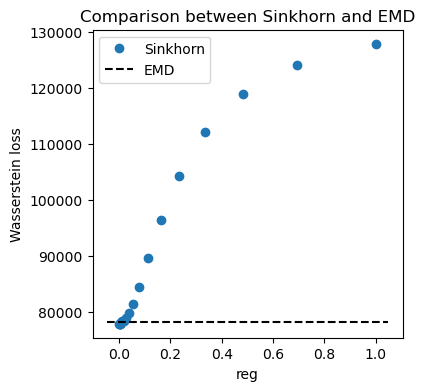

In [12]:
# Plot the matrix and the map
f = pl.figure(6, (4, 4))
pl.clf()
pl.title("Comparison between Sinkhorn and EMD")

pl.plot(reg_parameter, W_sinkhorn_reg, 'o', label="Sinkhorn")
XLim = pl.xlim()
pl.plot(XLim, [W, W], '--k', label="EMD")
pl.legend()
pl.xlabel("reg")
pl.ylabel("Wasserstein loss")